In [ ]:
import os
import torch
import torch.nn as nn
import math
import numpy as np

from rl_helpers.scalers import *
from torch.distributions import Bernoulli
from delivery_drone.game.socket_client import DroneGameClient, DroneState

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

In [ ]:
client = DroneGameClient(port=5555)
client.connect()

In [ ]:
from rl_helpers.scalers import *

### State Variables

| Variable | Min | Max | Typical Range | Critical Threshold |
|----------|-----|-----|---------------|-------------------|
| drone_x | 0 | 1 | [0, 1] | - |
| drone_y | 0 | 1 | [0, 1] | - |
| drone_vx | -2.5 | 2.5 | [-1.5, 1.5] | - |
| drone_vy | -2.5 | 3.0 | [-0.5, 2.5] | - |
| drone_angle | -1 | 1 | [-0.5, 0.5] | < 0.111 for landing |
| drone_angular_vel | -1.5 | 1.5 | [-0.8, 0.8] | - |
| drone_fuel | 0 | 1 | [0, 1] | Episode ends at 0 |
| platform_x | 0 | 1 | [0.1, 0.9] | - |
| platform_y | 0 | 1 | [0.58, 0.92] | Platform spawns at [350, 550]px |
| distance_to_platform | 0 | 1.41 | [0, 1.2] | - |
| dx_to_platform | -1.125 | 1.125 | [-1, 1] | < ±0.0625 for landing |
| dy_to_platform | -1.083 | 1.083 | [-0.5, 0.8] | - |
| speed | 0 | 3.9 | [0, 3.0] | < 0.3 for landing |

In [ ]:
def calc_velocity_alignment(state: DroneState):
    """
    Calculate how well the drone's velocity is aligned with optimal direction to platform.
    Returns cosine similarity: 1.0 = perfect alignment, -1.0 = opposite direction
    """
    # Optimal direction: from drone to platform
    optimal_dx = state.dx_to_platform
    optimal_dy = state.dy_to_platform
    optimal_norm = math.sqrt(optimal_dx**2 + optimal_dy**2)

    if optimal_norm < 1e-6:  # Already at platform
        return 1.0

    optimal_dx /= optimal_norm
    optimal_dy /= optimal_norm

    # Current velocity direction
    velocity_norm = state.speed
    if velocity_norm < 1e-6:  # Not moving
        return 0.0

    velocity_dx = state.drone_vx / velocity_norm
    velocity_dy = state.drone_vy / velocity_norm

    # Cosine similarity
    return velocity_dx * optimal_dx + velocity_dy * optimal_dy

In [ ]:
# Velocity-magnitude-weighted distance reward
def calc_reward(state: DroneState, prev_state: DroneState = None):
    rewards = {}
    total_reward = 0

    # Time penalty
    minimum_time_penalty = 0
    maximum_time_penalty = 1
    rewards['time_penalty'] = -inverse_quadratic(
        state.distance_to_platform,
        decay=100,
        scaler=maximum_time_penalty-minimum_time_penalty) - minimum_time_penalty

    # Distance-based time penalty
    # Penalty gets smaller as drone gets closer to platform
    # Uses inverse quadratic function: higher penalty when far, reduces as distance decreases
    # Minimum penalty of 0.5, maximum of 2.0 per timestep
    total_reward += -0.5#rewards['time_penalty']

    velocity_alignment = calc_velocity_alignment(state)
    dist = state.distance_to_platform
    
    rewards['distance'] = 0
    rewards['hovering'] = 0

    if prev_state is not None:
        distance_delta = prev_state.distance_to_platform - state.distance_to_platform
        speed = state.speed
        
        # Calculate velocity toward platform
        if dist > 1e-6:
            velocity_toward_platform = (
                state.drone_vx * state.dx_to_platform +
                state.drone_vy * state.dy_to_platform
            ) / dist
        else:
            velocity_toward_platform = 0.0
        
        MIN_MEANINGFUL_SPEED = 0.15  # Require meaningful velocity
        
        # Only reward if FAST and ALIGNED and making PROGRESS
        if speed >= MIN_MEANINGFUL_SPEED and velocity_toward_platform > 0.1 and dist > 0.065:
            # Good: Moving fast toward platform
            speed_multiplier = 1.0 + speed * 2.0
            rewards['distance'] = float(np.clip(distance_delta * 1000 * speed_multiplier, -2, 5))
        elif distance_delta < -0.001:
            # BAD: Moving away from platform (distance increasing)
            rewards['distance'] = -2.0 * abs(distance_delta) * 1000  # Harsh penalty
            rewards['hovering'] = 0  # Don't double-penalize
        elif speed < 0.05:
            # Hovering
            rewards['hovering'] = -1.0
        elif speed < MIN_MEANINGFUL_SPEED:
            # Too slow
            rewards['hovering'] = -0.3
        else:
            rewards['distance'] = 0.0
            
    total_reward += rewards['distance']
    total_reward += rewards['hovering']

    # Angle penalty (define a distance based max threshold)
    abs_angle = abs(state.drone_angle)
    max_angle = 0.20
    max_permissible_angle = ((max_angle-0.111)*dist) + 0.111
    excess = abs_angle - max_permissible_angle # excess angle
    rewards['angle'] = -max(excess, 0) # maximum reward is 0 (we dont want it to reward hack for stability)

    total_reward += rewards['angle']

    # Speed - penalize excessive speed
    rewards['speed'] = 0
    speed = state.speed
    max_speed = 0.6
    if dist < 1:
        rewards['speed'] = -2 * max(speed-0.1, 0)
    else:
        rewards['speed'] = -1 * max(speed-max_speed, 0)
    total_reward += rewards['speed']

    # Penalize being below platform
    rewards['vertical_position'] = 0
    if state.dy_to_platform > 0:  # Platform is below drone (drone is above - GOOD)
        rewards['vertical_position'] = 0
    else:  # Drone is below platform (BAD!)
        rewards['vertical_position'] = state.dy_to_platform * 4.0  # Negative penalty
    total_reward += rewards['vertical_position']

    # Terminal
    rewards['terminal'] = 0
    if state.landed:
        rewards['terminal'] = 800.0 + state.drone_fuel * 100.0
    elif state.crashed:
        rewards['terminal'] = -200.0
        # Extra penalty for crashing far from target
        if state.distance_to_platform > 0.3:
            rewards['terminal'] -= 100.0
    total_reward += rewards['terminal']

    rewards['total'] = total_reward
    return rewards

In [ ]:
client.reset()
state=None

In [ ]:
prev_state = state if state else None
client.step(
    dict(
        main_thrust=0,
        left_thrust=0,
        right_thrust=0
    )
)
state = client.get_state()
display(state.__dict__)
calc_reward(state, prev_state)

### Deep Learning begins from here

In [ ]:
def state_to_array(state, device='cpu'):
    """Convert DroneState dataclass to numpy array"""
    data = np.array([
        state.drone_x,
        state.drone_y,
        state.drone_vx,
        state.drone_vy,
        state.drone_angle,
        state.drone_angular_vel,
        state.drone_fuel,
        state.platform_x,
        state.platform_y,
        state.distance_to_platform,
        state.dx_to_platform,
        state.dy_to_platform,
        state.speed,
        float(state.landed),
        float(state.crashed)
    ])
    
    return torch.tensor(data, dtype=torch.float32, device=device)

In [ ]:
class DroneGamerBoi(nn.Module):
    def __init__(self, state_dim=15):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.LayerNorm(128),  # Add normalization
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Sigmoid()
        )
        
    def forward(self, state):
        if isinstance(state, DroneState):
            state = state_to_array(state, device=device)
        
        return self.network(state)

In [ ]:
class DroneTeacherBoi(nn.Module):
    def __init__(self, state_dim=15):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.LayerNorm(128),  # Add normalization
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 1) # output will be just a scalar
        )
        
    def forward(self, state):
        if isinstance(state, DroneState):
            state = state_to_array(state, device=device)
        
        return (self.network(state)
                .squeeze(-1)) # this will convert the tensor from [B, 1] to [B,]

## Basic Actor-Critic: How It Works

Actor-Critic combines two neural networks working together:

1. **Actor (Policy Network)**: Decides which actions to take
2. **Critic (Value Network)**: Evaluates how good the current state is

### The Key Idea

Instead of waiting for the full episode to finish (like in Policy Gradients), Actor-Critic updates **after each step** using the critic's estimate of future rewards.

### Components

**Actor Network**: $\pi_\theta(a|s)$
- Input: state $s$ (15 features)
- Output: action probabilities for each thruster
- Parameters: $\theta$

**Critic Network**: $V_\phi(s)$
- Input: state $s$ (15 features)  
- Output: single scalar value (estimated future return)
- Parameters: $\phi$

### The Update Process

At each timestep $t$:

1. **Act**: Sample action $a_t \sim \pi_\theta(a_t|s_t)$ from the actor
2. **Observe**: Get reward $r_t$ and next state $s_{t+1}$
3. **Compute TD Error** (this is the advantage):
$$\delta_t = r_t + \gamma V_\phi(s_{t+1}) - V_\phi(s_t)$$

**What is TD error?**
- $r_t + \gamma V_\phi(s_{t+1})$: immediate reward + estimated future value (TD target)
- $V_\phi(s_t)$: what we predicted the value would be
- $\delta_t$: how wrong we were (positive = better than expected, negative = worse)

4. **Update Critic**: Make value prediction more accurate
$$L_{\text{critic}} = \delta_t^2 = \left(r_t + \gamma V_\phi(s_{t+1}) - V_\phi(s_t)\right)^2$$

Minimize this MSE loss with gradient descent on $\phi$

5. **Update Actor**: Reinforce good actions, discourage bad ones
$$L_{\text{actor}} = -\log \pi_\theta(a_t|s_t) \cdot \delta_t$$

If $\delta_t > 0$ (better than expected): increase probability of $a_t$  
If $\delta_t < 0$ (worse than expected): decrease probability of $a_t$

### Why Is This Better Than Policy Gradients?

**Policy Gradients (REINFORCE)**:
- Uses full episode return $G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}$
- High variance (one lucky/unlucky episode affects learning a lot)
- Must wait until episode ends

**Actor-Critic**:
- Uses TD error $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ (single-step estimate)
- Lower variance (critic averages over many experiences)
- Updates immediately after each step (online learning)

The trade-off: slight bias (depends on critic accuracy) but much lower variance = faster, more stable learning!

In [ ]:
# Function to calculate -log(prob) * advantage
def neg_log_prob_loss(action_probs, action_index, reward):
    """
    Computes the negative log-probability loss for policy gradient methods.

    Args:
        action_probs (torch.Tensor): Tensor of probabilities for each action.
        action_index (int): Index of the action taken.
        reward (float): Scalar reward. Can be replaced by advantage for advantage-based methods.

    Returns:
        torch.Tensor: The computed loss value.
    """

    loss = -torch.log(action_probs[action_index]) * reward
    return loss

# Function calculate the Temporal Difference error δ (delta)
# δ_t = r_t + γV(s_{t+1}) - V(s_t)
def compute_td_error(value_current_state, value_next_state, reward, gamma):
    """
    Computes the Temporal Difference (TD) error for Actor-Critic methods.
    
    TD error (δ) represents the difference between the TD target (r + γV(s')) 
    and the current value estimate V(s).
    
    Args:
        value_current_state (torch.Tensor): Value estimate of current state V(s_t)
        value_next_state (torch.Tensor): Value estimate of next state V(s_{t+1})
        reward (float): Immediate reward r_t
        gamma (float): Discount factor for future rewards
    
    Returns:
        torch.Tensor: TD error δ_t = r_t + γV(s_{t+1}) - V(s_t)
    """
    
    td_target = reward + gamma * value_next_state
    td_error = td_target -value_current_state
    return td_target, td_error

#### Online vs Episodic updates

In Basic Actor-Critic, we perform **online updates** - meaning the networks are updated immediately after each action, rather than waiting for the episode to complete. 

After every step:
1. Execute action $a_t$, observe $r_t$ and $s_{t+1}$
2. Compute TD error: $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$
3. Update both actor and critic networks immediately

This is different from Policy Gradients where we collected full episodes before updating. Online learning allows faster adaptation but can be noisier since we update from single transitions instead of complete trajectories.

In [ ]:
import time

from tqdm.notebook import trange, tqdm

In [ ]:
policy = DroneGamerBoi().to(device) # initialize our policy
critic = DroneTeacherBoi().to(device) # initialize our critic
policy_optimizer = torch.optim.AdamW(policy.parameters(), lr=1e-3)
critic_optimizer = torch.optim.AdamW(critic.parameters(), lr=1e-3)

In [ ]:
# training configurations
num_iterations = 1000
num_episodes = client.num_games

bellman_gamma = 0.99

In [ ]:
def run_single_step(client: DroneGameClient, policy: DroneGamerBoi, game_states, prev_game_states, games_done, step_counts, max_steps):
    """
    Run a single step for all active parallel games and return batched transition data.
    
    Args:
        client: DroneGameClient instance
        policy: Actor (policy) network
        game_states: List of current DroneState for each game
        prev_game_states: List of previous DroneState for each game (for reward calculation)
        games_done: List[bool] indicating if each game is terminated
        step_counts: List[int] tracking steps taken per game
        max_steps: Maximum steps allowed per episode
        
    Returns:
        batch_data: Dict with batched tensors, or None if no active games
        game_states: Updated list of game states
        prev_game_states: Updated list of previous game states
    """
    num_games = client.num_games
    
    # Storage for batch data
    states_list = []
    actions_list = []
    log_probs_list = []
    rewards_list = []
    next_states_list = []
    dones_list = []
    game_ids_list = []
    
    # Collect states from active games
    batch_states = []
    active_game_ids = []
    
    for game_id in range(num_games):
        if not games_done[game_id]:
            batch_states.append(state_to_array(game_states[game_id], device=device))
            active_game_ids.append(game_id)
    
    # Early exit if all games are done
    if len(batch_states) == 0:
        return None, game_states, prev_game_states
    
    # Batched policy inference (forward pass through actor network)
    batch_states_tensor = torch.stack(batch_states)
    batch_action_probs = policy(batch_states_tensor)
    batch_dist = Bernoulli(probs=batch_action_probs)
    batch_actions = batch_dist.sample()
    batch_log_probs = batch_dist.log_prob(batch_actions).sum(dim=1)
    
    # Execute actions in environment for each active game
    for i, game_id in enumerate(active_game_ids):
        action = batch_actions[i]
        log_prob = batch_log_probs[i]
        state_tensor = batch_states[i]
        
        # Store previous state before stepping
        prev_state = game_states[game_id]
        
        # Step the environment
        next_state, _, done, _ = client.step({
            "main_thrust": int(action[0]),
            "left_thrust": int(action[1]),
            "right_thrust": int(action[2])
        }, game_id)
        
        # Compute reward from next state WITH previous state for velocity-weighted rewards
        reward_dict = calc_reward(next_state, prev_state=prev_state)
        reward = reward_dict['total']
        
        # Increment step counter
        step_counts[game_id] += 1
        
        # Check for timeout (max_steps reached without landing)
        if step_counts[game_id] >= max_steps:
            if not next_state.landed:
                reward -= 500  # Apply timeout penalty
            done = True  # Force termination
        
        # Convert next state to tensor
        next_state_tensor = state_to_array(next_state, device=device)
        
        # Store transition data
        states_list.append(state_tensor)
        actions_list.append(action)
        log_probs_list.append(log_prob)
        rewards_list.append(reward)
        next_states_list.append(next_state_tensor)
        dones_list.append(float(done))
        game_ids_list.append(game_id)
        
        # Update game state for next iteration
        prev_game_states[game_id] = game_states[game_id]
        game_states[game_id] = next_state
    
    # Create batched tensors for training
    batch_data = {
        'states': torch.stack(states_list),
        'actions': torch.stack(actions_list),
        'log_probs': torch.stack(log_probs_list),
        'rewards': torch.tensor(rewards_list, dtype=torch.float32, device=device),
        'next_states': torch.stack(next_states_list),
        'dones': torch.tensor(dones_list, dtype=torch.float32, device=device),
        'game_ids': game_ids_list
    }
    
    return batch_data, game_states, prev_game_states

In [ ]:
def evaluate_policy_simple(client, policy, max_steps=300, game_id=0, temperature=0.5, iteration=0, fig_ax=None):
    """
    Simple evaluation with static plots that reuse the same figure.
    Auto-detects reward components from calc_reward() output.
    """
    import matplotlib.pyplot as plt
    
    policy.eval()
    state = client.reset(game_id)
    prev_state = None
    
    # Initialize with empty dicts - will be populated dynamically
    history = {'step': []}
    accumulated = {}
    
    steps = 0
    done = False
    
    # Run episode
    while not done and steps < max_steps:
        with torch.no_grad():
            action_probs = policy(state)
            
        if temperature == 0:
            action = (action_probs > 0.5).float()
        else:
            adjusted_probs = torch.pow(action_probs, 1.0 / temperature)
            adjusted_probs = adjusted_probs / (adjusted_probs + torch.pow(1 - action_probs, 1.0 / temperature))
            dist = Bernoulli(probs=adjusted_probs)
            action = dist.sample()
        
        prev_state = state
        next_state, _, done, _ = client.step({
            "main_thrust": int(action[0]),
            "left_thrust": int(action[1]),
            "right_thrust": int(action[2])
        }, game_id)
        
        reward = calc_reward(next_state, prev_state=prev_state)
        
        # Initialize components on first step
        if steps == 0:
            for key in reward.keys():
                history[key] = []
                accumulated[key] = 0
        
        # Accumulate rewards
        for key in reward.keys():
            accumulated[key] += reward[key]
        
        # Store history
        history['step'].append(steps)
        for key in reward.keys():
            history[key].append(accumulated[key])
        
        state = next_state
        steps += 1
    
    policy.train()
    
    # Create or reuse figure
    if fig_ax is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    else:
        fig, (ax1, ax2) = fig_ax
        ax1.clear()
        ax2.clear()
    
    # Plot 1: All components (auto-detected, exclude 'total')
    components = [key for key in history.keys() if key not in ['step', 'total']]
    for comp in components:
        ax1.plot(history['step'], history[comp], label=comp, linewidth=2)
    
    ax1.set_xlabel('Time Steps', fontsize=11)
    ax1.set_ylabel('Accumulated Reward', fontsize=11)
    ax1.set_title(f'Accumulated Reward by Component (Iter {iteration})', fontweight='bold', fontsize=12)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Total
    if 'total' in history:
        ax2.plot(history['step'], history['total'], color='black', linewidth=3)
    ax2.set_xlabel('Time Steps', fontsize=11)
    ax2.set_ylabel('Accumulated Reward', fontsize=11)
    ax2.set_title(f'Total Accumulated Reward (Iter {iteration})', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add result annotation
    status = "[LANDED]" if state.landed else "[CRASHED]"
    color = 'green' if state.landed else 'red'
    result_text = f"{status} | Steps: {steps} | Total: {accumulated['total']:.1f} | Fuel: {state.drone_fuel:.1%}"
    
    # Clear previous suptitle and add new one
    fig.suptitle(result_text, fontsize=13, fontweight='bold', color=color, y=1.02)
    
    plt.tight_layout()
    
    # Display the figure using IPython display
    display(fig)
    
    return {
        'landed': state.landed,
        'steps': steps,
        'total_reward': accumulated['total'],
        'final_fuel': state.drone_fuel
    }, (fig, (ax1, ax2))

In [ ]:
steepness = 0.65
start = 300
end = 300 # Same value for start and end disables dynamic episode lengths, 
# Can explore further later
x = np.linspace(0, 1, num=num_iterations)
step_schedule = np.round(start + (end - start) * x**steepness).astype(np.int32)

In [ ]:
# Evaluation settings
eval_interval = 10
eval_temperature = 0.3
num_games = client.num_games

# Shared figure object
eval_fig_ax = None

tqdm_iterations = trange(num_iterations, desc='', total=num_iterations)

# Training loop: each iteration runs parallel games until all complete
for iteration in tqdm_iterations:
    max_steps = step_schedule[iteration]
    
    # Reset all games and initialize tracking
    game_states = [client.reset(game_id) for game_id in range(num_games)]
    prev_game_states = [None] * num_games  # Initialize prev_game_states
    games_done = [False] * num_games
    step_counts = [0] * num_games  # Track steps per game
    
    # Metrics for this iteration
    actor_losses = []
    critic_losses = []
    episode_rewards = [0] * num_games
    num_successes = 0
    
    # Run all games until completion
    while not all(games_done):
        # Collect transitions from one step across all active games
        batch_data, game_states, prev_game_states = run_single_step(
            client, policy, game_states, prev_game_states, games_done, step_counts, max_steps
        )
        
        if batch_data is None:  # All games finished
            break
        
        # === CRITIC UPDATE ===
        # Compute value estimates
        values = critic(batch_data['states'])
        with torch.no_grad():  # FIX: Detach next_values!
            next_values = critic(batch_data['next_states'])
        
        # next_values = critic(batch_data['next_states'])
        
        # Compute TD targets: r + γ*V(s')*(1-done)
        td_targets = (batch_data['rewards'] + 
                      bellman_gamma * next_values * (1 - batch_data['dones']))
        
        # Compute TD errors: δ = TD_target - V(s)
        td_errors = td_targets - values
        
        # Critic loss: MSE of TD errors
        critic_loss = (td_errors ** 2).mean()
        
        # Add value regularization
        value_reg = 0.01 * (values ** 2).mean()
        critic_loss = critic_loss + value_reg
        
        # Update critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=0.5)
        critic_optimizer.step()
        
        # === ACTOR UPDATE ===
        # Actor loss: -log π(a|s) * δ (detach δ to stop gradients from critic)
        actor_loss = -(batch_data['log_probs'] * td_errors.detach()).mean()
        
        # Update actor
        policy_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=0.5)
        policy_optimizer.step()
        
        # Track losses
        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        
        # Track episode metrics and check for completion
        for i, game_id in enumerate(batch_data['game_ids']):
            episode_rewards[game_id] += batch_data['rewards'][i].item()
            
            # Check if this game just finished
            if batch_data['dones'][i] == 1.0:
                games_done[game_id] = True
                if game_states[game_id].landed:
                    num_successes += 1
    # Compute iteration statistics
    avg_actor_loss = sum(actor_losses) / len(actor_losses) if actor_losses else 0.0
    avg_critic_loss = sum(critic_losses) / len(critic_losses) if critic_losses else 0.0
    avg_reward = sum(episode_rewards) / num_games
    avg_steps = sum(step_counts) / num_games
    
    # Update progress bar
    tqdm_iterations.set_description(
        f'Success: {num_successes}/{num_games} | '
        f'Avg Reward: {avg_reward:.1f} | '
        f'Actor: {avg_actor_loss:.4f} | '
        f'Critic: {avg_critic_loss:.4f} | '
        f'Steps: {avg_steps:.1f}'
    )
    
    # Periodic evaluation
    if (iteration + 1) % eval_interval == 0:
        eval_result, eval_fig_ax = evaluate_policy_simple(
            client, 
            policy, 
            max_steps=500,
            temperature=eval_temperature,
            iteration=iteration + 1,
            game_id=0,
            fig_ax=eval_fig_ax
        )

In [ ]:
torch.save(policy.state_dict(), './models/actor-critic-basic/drone_policy_v3.pth')

In [ ]:
state=client.get_state(0)
display(state.__dict__)
display(calc_reward(state))
calc_velocity_alignment(state)

In [ ]:
def evaluate_policy(client, policy, max_steps=300, game_id=0, temperature=0.5):
    """
    Evaluate policy on a single game without training.
    
    Args:
        client (DroneGameClient): Game client instance
        policy (DroneGamerBoi): Policy network
        max_steps (int): Maximum steps per episode
        game_id (int): ID of the game to evaluate
        
    Returns:
        dict: Episode statistics including rewards, steps, and outcome
    """
    # Set policy to evaluation mode
    policy.eval()
    
    # Initialize episode
    state = client.reset(game_id)
    prev_state = None
    total_reward = 0
    rewards = []
    steps = 0
    done = False
    
    # Run episode
    while not done and steps < max_steps:
        # Get action probabilities from policy
        with torch.no_grad():  # Disable gradient computation
            action_probs = policy(state)
            
        if temperature == 0:
            action = (action_probs > 0.5).float()
        else:
            adjusted_probs = torch.pow(action_probs, 1.0 / temperature)
            adjusted_probs = adjusted_probs / (adjusted_probs + torch.pow(1 - action_probs, 1.0 / temperature))
            # Sample action from probabilities
            dist = Bernoulli(probs=adjusted_probs)
            action = dist.sample()
        
        # Take action in environment
        prev_state = state
        next_state, _, done, _ = client.step({
            "main_thrust": int(action[0]),
            "left_thrust": int(action[1]),
            "right_thrust": int(action[2])
        }, game_id)
        
        # Calculate reward with prev_state
        reward = calc_reward(next_state, prev_state=prev_state)
        total_reward += reward['total']
        rewards.append(reward)
        
        # Update state and step counter
        state = next_state
        steps += 1
        
    # Return episode statistics
    return {
        'total_reward': total_reward,
        'rewards': rewards,
        'steps': steps,
        'landed': state.landed,
        'crashed': state.crashed,
        'final_fuel': state.drone_fuel
    }


In [ ]:
def plot_accumulated_rewards(results, figsize=(14, 8)):
    """
    Plot accumulated rewards for each component over time.
    
    Args:
        results: Output from evaluate_policy() containing 'rewards' list
        figsize: Figure size tuple (width, height)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract reward components
    reward_dicts = results['rewards']
    steps = len(reward_dicts)
    
    # Get all component keys (exclude 'total')
    components = [key for key in reward_dicts[0].keys() if key != 'total']
    
    # Initialize accumulated rewards
    accumulated = {comp: [] for comp in components}
    accumulated['total'] = []
    
    # Calculate accumulated rewards for each component
    for comp in components:
        cumsum = 0
        for reward_dict in reward_dicts:
            cumsum += reward_dict[comp]
            accumulated[comp].append(cumsum)
    
    # Calculate accumulated total
    cumsum_total = 0
    for reward_dict in reward_dicts:
        cumsum_total += reward_dict['total']
        accumulated['total'].append(cumsum_total)
    
    # Create plot
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Plot 1: All components separately
    ax1 = axes[0]
    for comp in components:
        ax1.plot(accumulated[comp], label=comp, linewidth=2)
    
    ax1.set_title('Accumulated Reward by Component', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Accumulated Reward')
    ax1.legend(loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Total accumulated reward
    ax2 = axes[1]
    ax2.plot(accumulated['total'], color='black', linewidth=3, label='Total')
    ax2.set_title('Total Accumulated Reward', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Accumulated Reward')
    ax2.legend(loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
policy = DroneGamerBoi().to(device)
policy.load_state_dict(torch.load('./models/actor-critic-basic/drone_policy_v2.pth'))
policy.eval()  # Set to evaluation mode

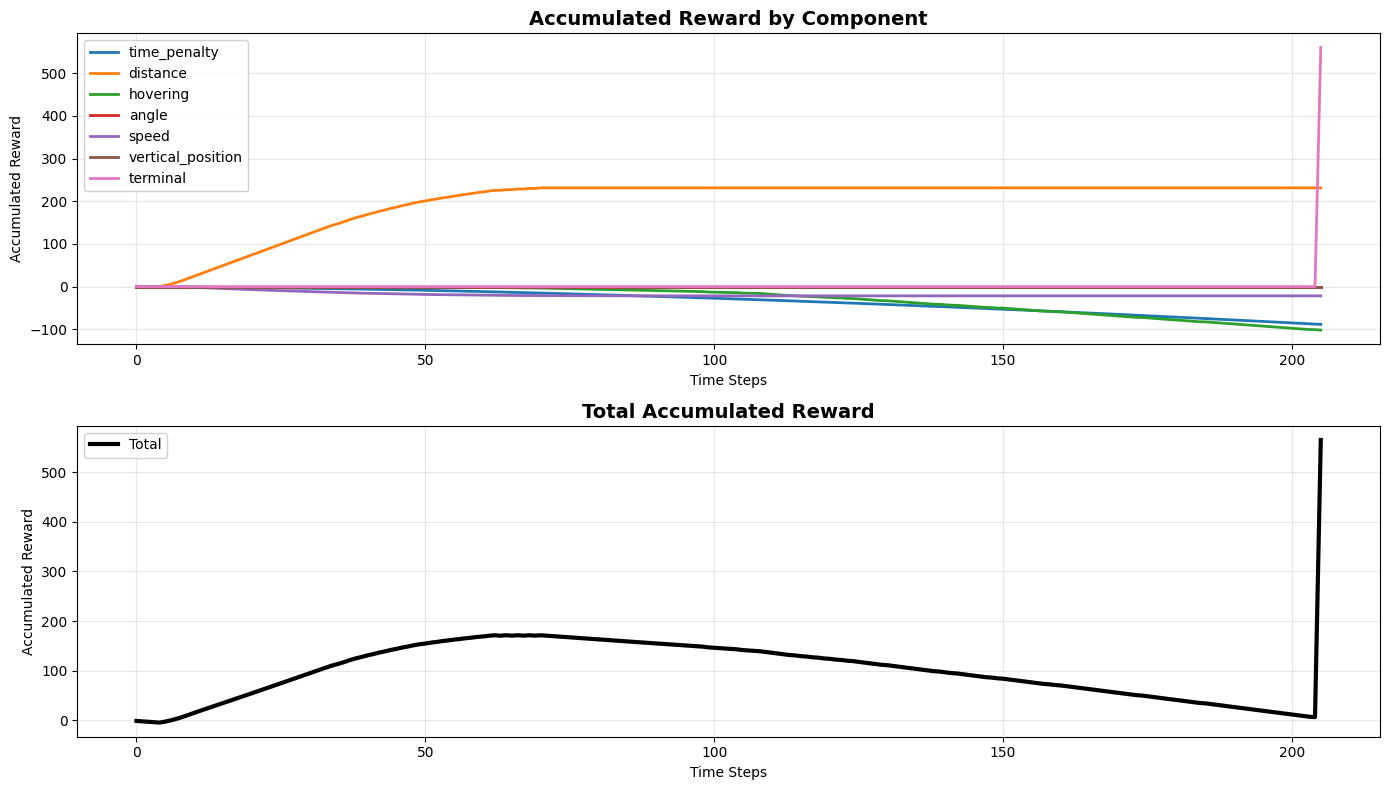

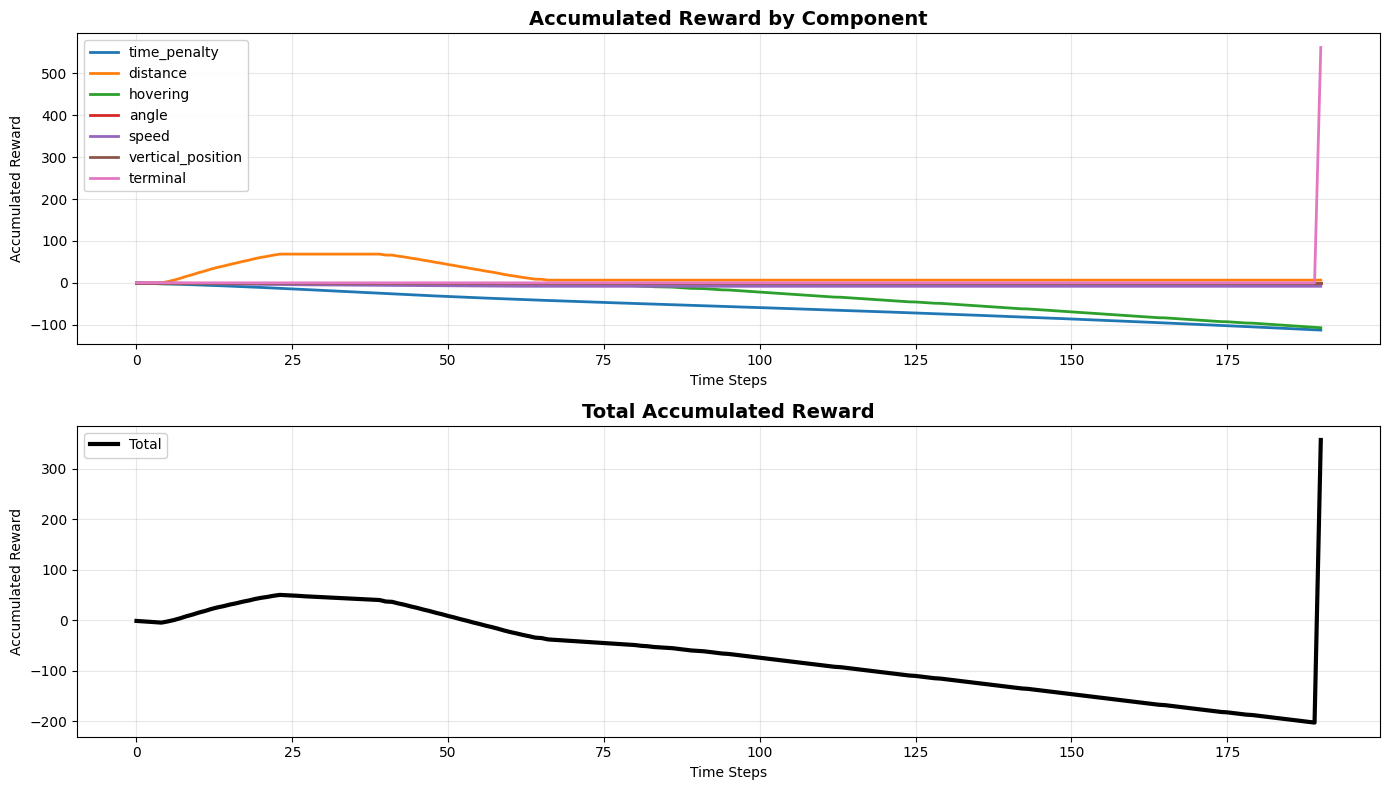

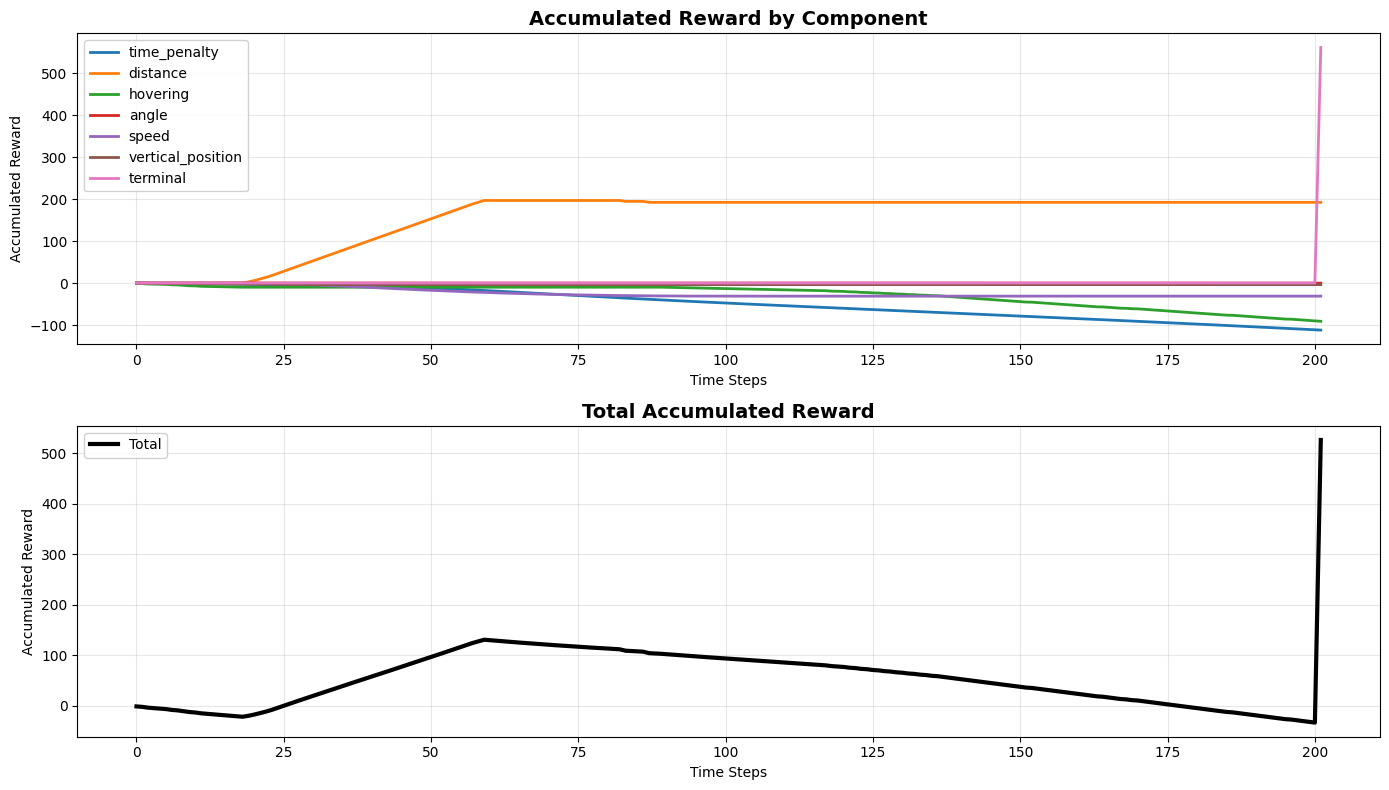

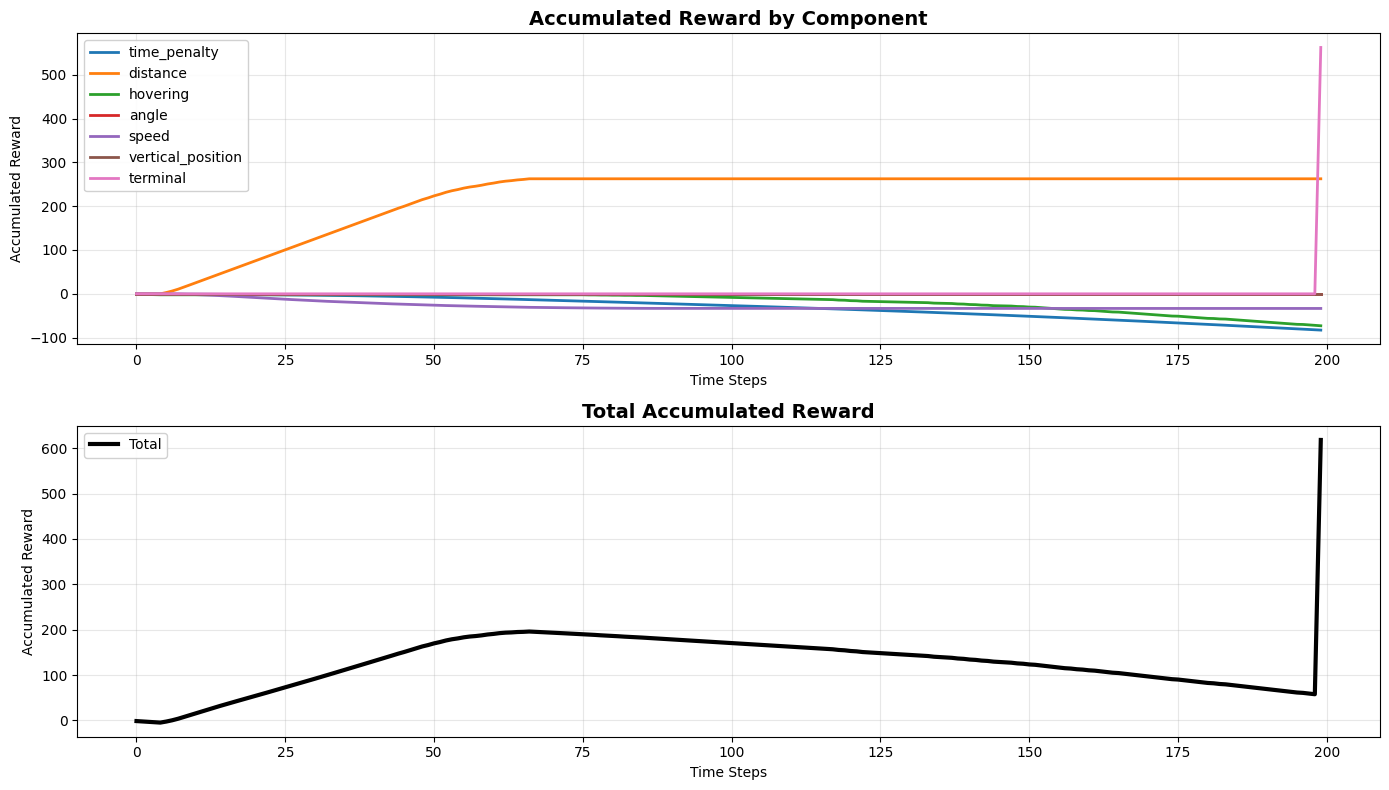

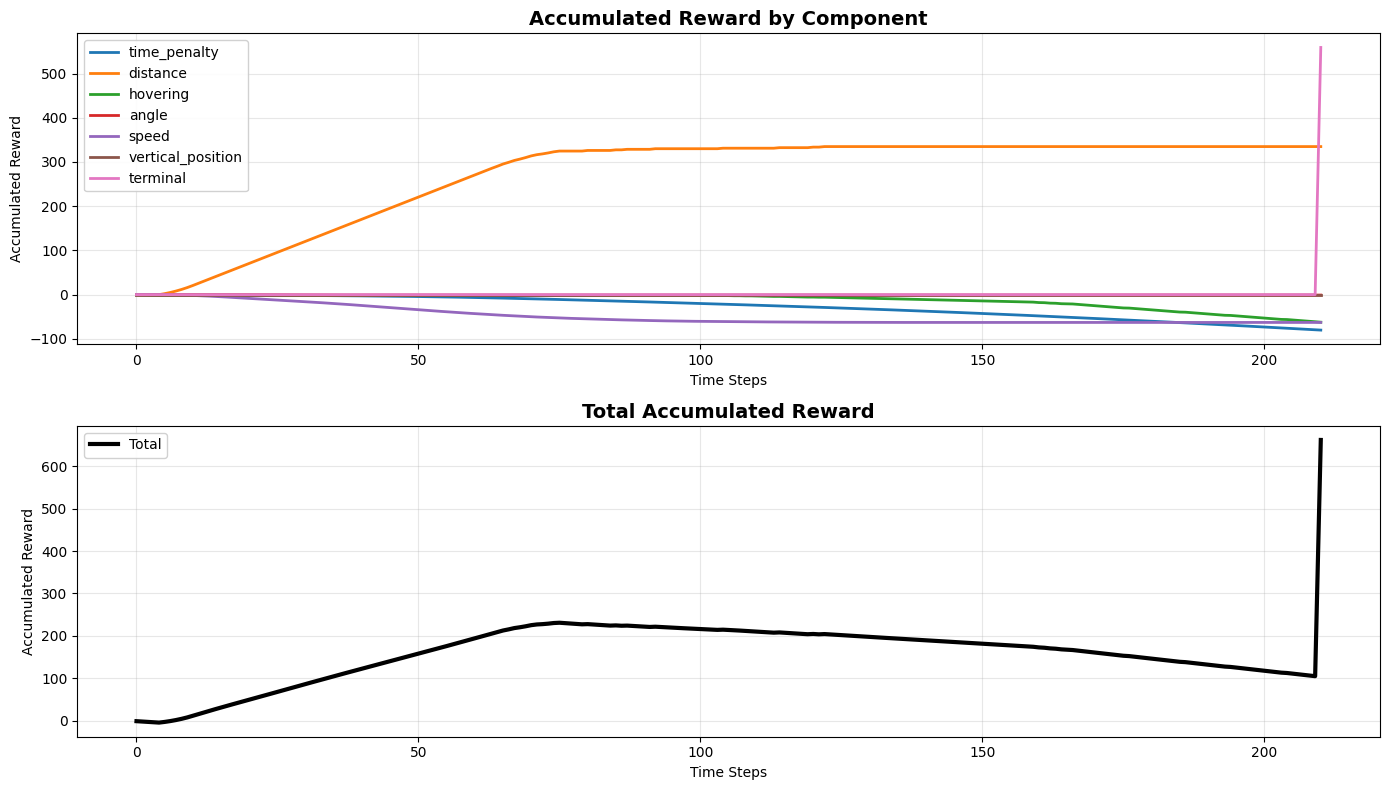

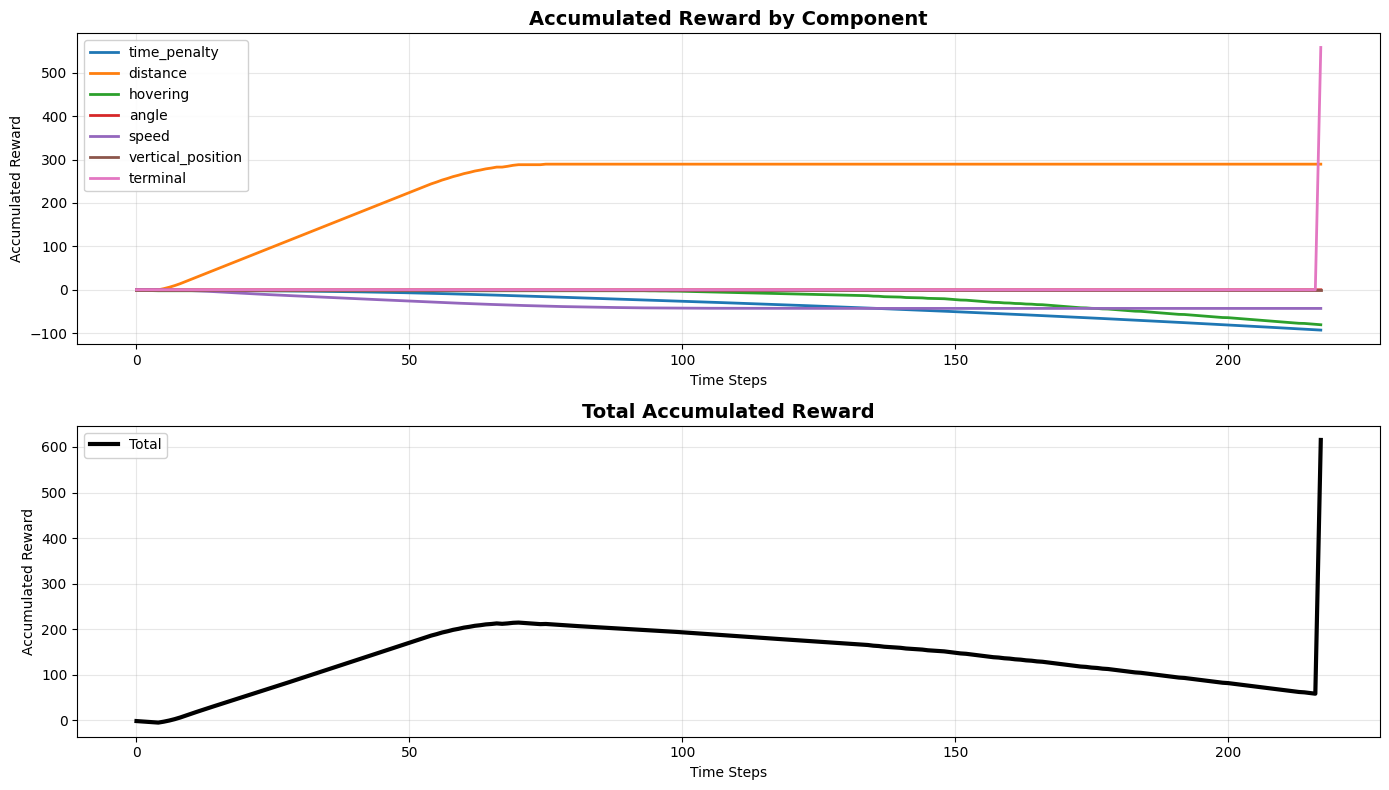

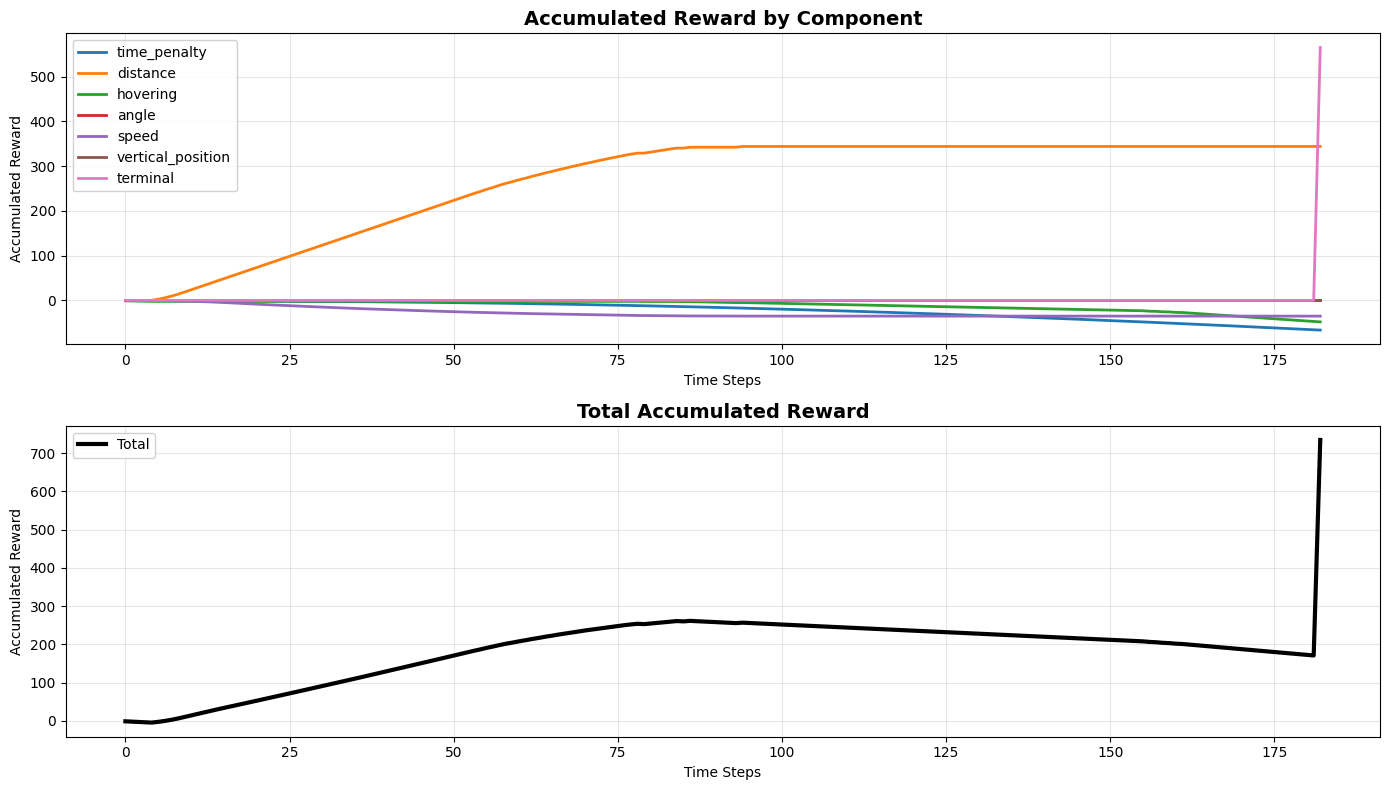

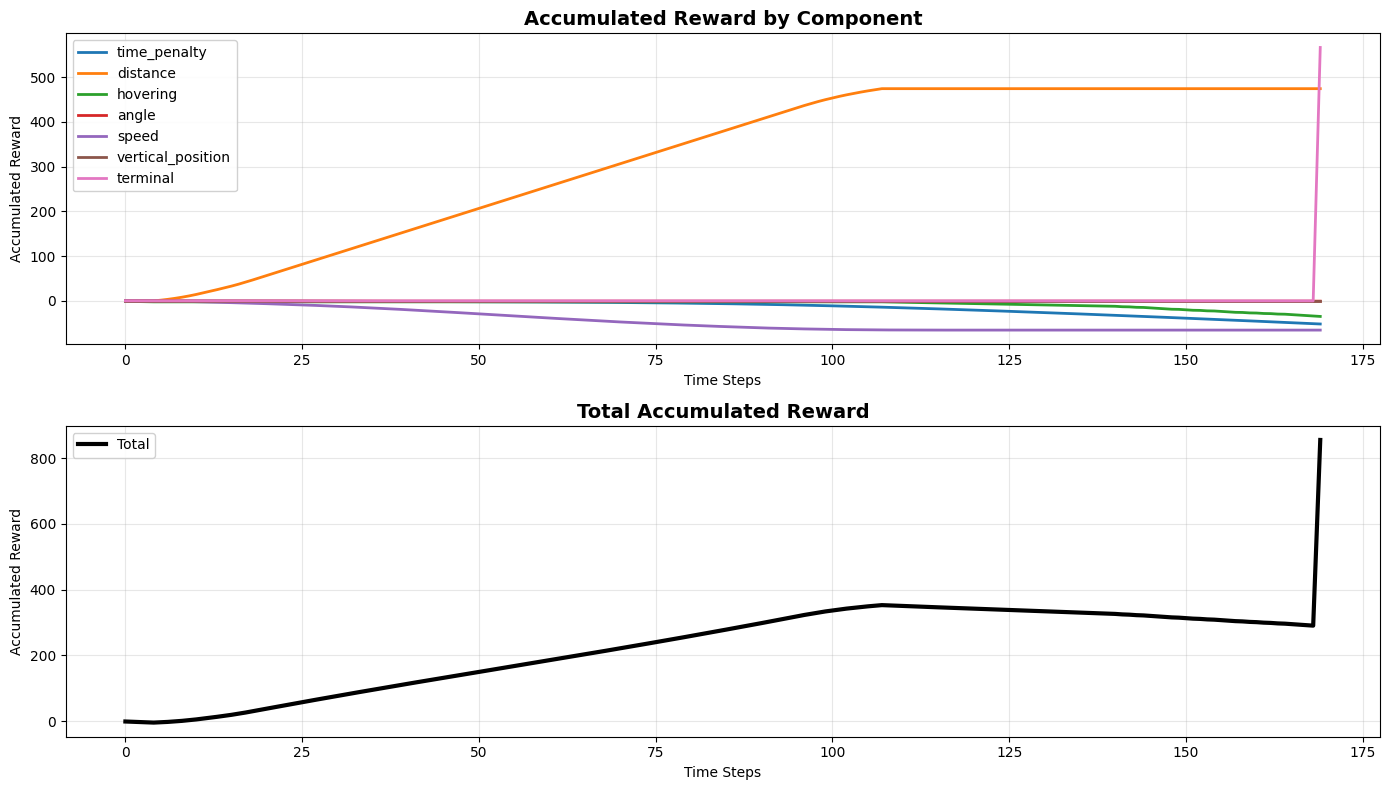

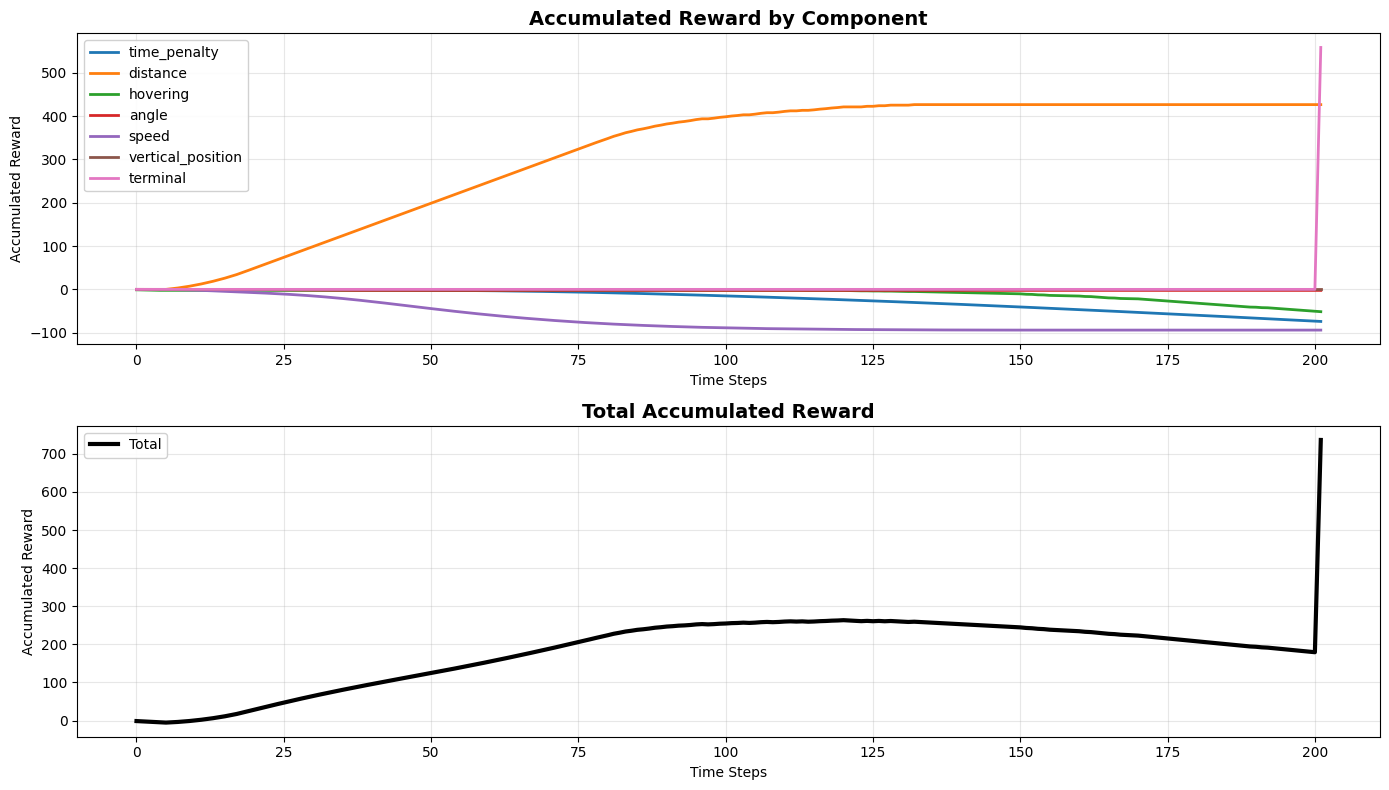

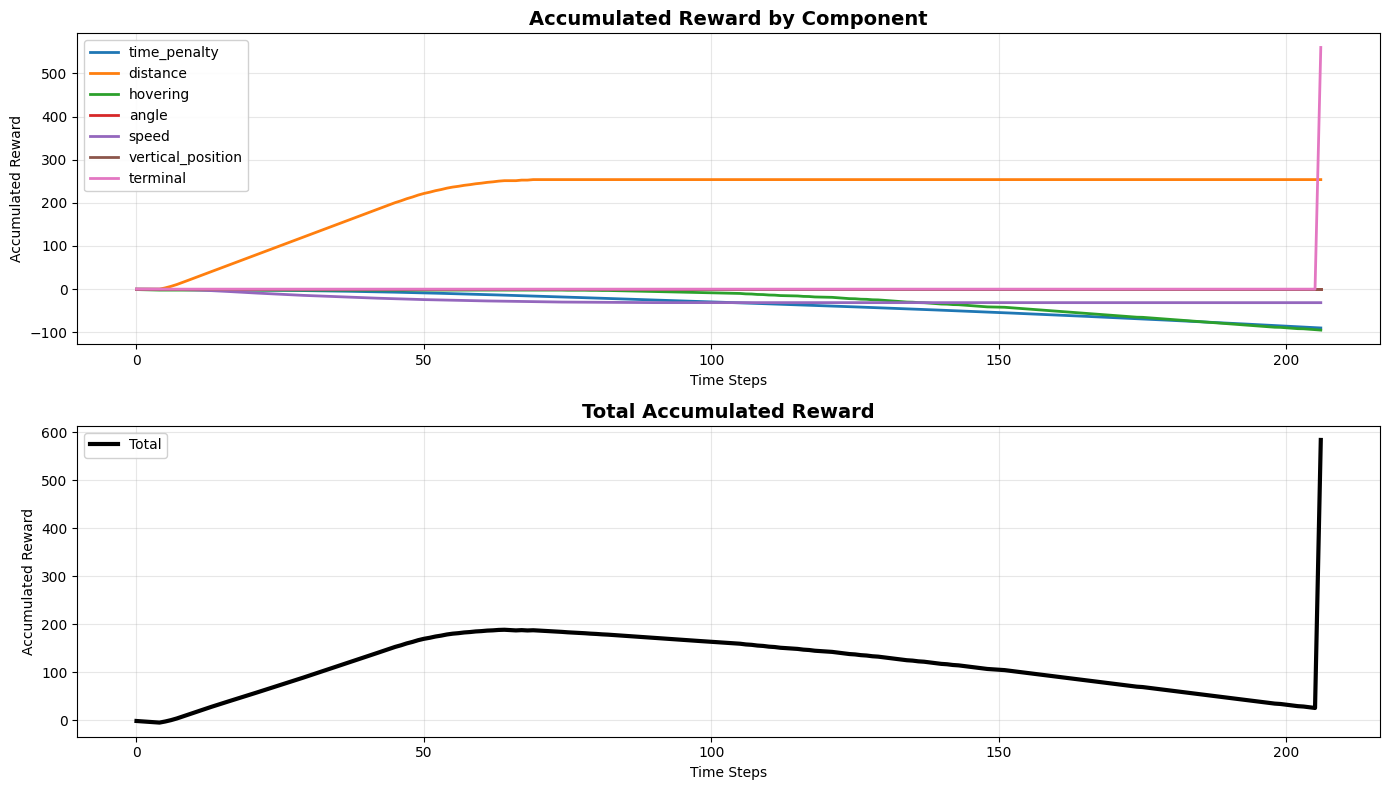

In [30]:
for _ in range(10):
    plot_accumulated_rewards(evaluate_policy(client, policy, max_steps=1000, temperature=1))